In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da
from geopy.distance import geodesic

In [2]:
pathdat = "../data/track_data/csvs/Teddy_2020.csv"

In [3]:
df = pd.read_csv(pathdat)
hurrlats, hurrlons = df['LAT'].values, df['LON'].values

In [4]:
hurrtnum = np.ones_like(hurrlats)
for i in range(len(hurrlats)):
    hdate = datetime.datetime(2000+int(df['DATE'][i][5:7]),int(df['DATE'][i][0]),int(df['DATE'][i][2:4]),np.mod(6+3*i,24))
    hurrtnum[i] = mdates.date2num(hdate)

In [5]:
dataloc = "../data/ru33-20200826T1604_a562_588d_4ec2.nc"

In [6]:
df = xr.open_dataset(dataloc, decode_times=False)

In [7]:
glats = df.latitude.values
glons = df.longitude.values

In [9]:
distance_metric = np.ones((np.size(glats),np.size(hurrlats)))
for i, glatitude in enumerate(glats):
    for j, hlatitude in enumerate(hurrlats):
        glider_LL = (glatitude, glons[i])
        hurr_ll   = (hlatitude, hurrlons[j])
        distance_metric[i,j] = geodesic(glider_LL, hurr_ll).miles

In [10]:
b = np.amin(distance_metric)
print(b)
ktime = np.where(distance_metric == b)[1][0]
eyepassage = hurrtnum[ktime]

500.1914742655035


In [11]:
time_origin = datetime.datetime(1970,1,1)
datenum = np.ones_like(df.depth.values)
for i, sec in enumerate(df.time.values[:]):
    datetmp   = time_origin + datetime.timedelta(seconds = sec)
    datenum[i] = mdates.date2num(datetmp)

In [33]:
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
start = mdates.date2num(datetime.datetime(2020,9,21,12))
enddd = mdates.date2num(datetime.datetime(2020,9,28,0))

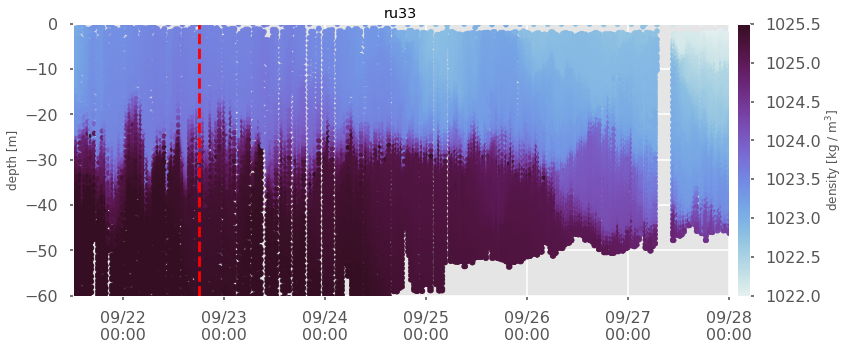

In [34]:
plt.figure(figsize=(14,5))
plt.title('ru33')
plt.scatter(datenum, -df.depth, c=df.density, cmap=cmo.dense, vmax=1025.5, s=25)
plt.colorbar(pad=0.01, label="density [kg / m$^3$]")
plt.xlim([start, enddd])
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.ylabel('depth [m]')
plt.ylim([-60,0])
plt.gca().xaxis.set_major_formatter(myFmt)

In [35]:
### binning
x = datenum #[0,:,:].reshape(np.size(datenum[0,:,:]))
y = -df.depth.values #[0,:,:].values.reshape(np.size(datenum[0,:,:]))
t = df.temperature.values #[0,:,:].values.reshape(np.size(datenum[0,:,:]))
timepoints = int((enddd - start)*48)+1 #
tgrid = np.linspace(start,enddd,timepoints)
zgrid = np.linspace(-55,-5, 51)
T, Z = np.meshgrid(tgrid,zgrid)

In [36]:
TEMPS = np.ones_like(T)
np.shape(TEMPS)

(51, 313)

In [37]:
for i in range(len(tgrid)-1):
    Tmore = x > tgrid[i]
    Tless = x < tgrid[i+1]
    qT = np.logical_and(Tmore,Tless)
    for j in range(len(zgrid)-1):
        Zmore = y > zgrid[j]
        Zless = y < zgrid[j+1]
        qZ = np.logical_and(Zmore,Zless)
        qALL = np.logical_and(qZ,qT)
        xZ = x[qALL]
        yZ = y[qALL]
        tZ = t[qALL]
        if len(tZ) > 0:
            TEMPS[j,i] = np.nanmedian(tZ)
        else:
            TEMPS[j,i] = np.nan

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [38]:
st = mdates.date2num(datetime.datetime(2020,9,25,12))
en = mdates.date2num(datetime.datetime(2020,9,26,0))

a = tgrid < en
b = tgrid > st
q = np.logical_and(a,b)
temps_before = TEMPS[:,q]
temps_before = np.nanmean(temps_before, axis=(1))

temps_before.shape

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


(51,)

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


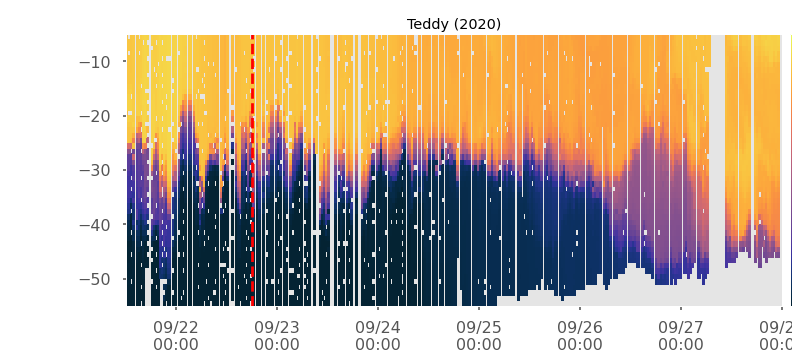

In [39]:
plt.figure(figsize=(14,5))
plt.pcolor(T, Z, TEMPS, cmap=cmo.thermal, vmin=9, vmax=22)
plt.colorbar(pad=0.01, label="temperature [C]")
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.axvline(x = eyepassage, c='r', linestyle="--")
#plt.scatter(ndb_datenum, -(windspeed), c=winddir, s=36, vmin=0, vmax=360, cmap=cmo.phase)
plt.title('Teddy (2020)')
plt.savefig("FIGS/temperatures_Teddy2020.pdf", bbox_inches='tight')
plt.show()

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


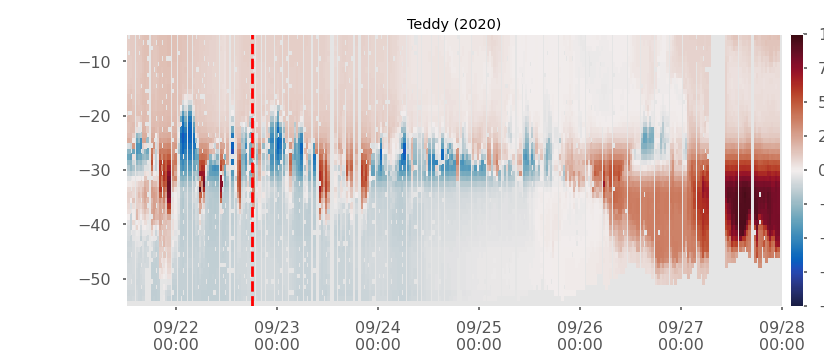

In [40]:
plt.figure(figsize=(14,5))
plt.pcolor(T, Z, TEMPS-temps_before[:,np.newaxis], cmap=cmo.balance, vmin=-10, vmax=10)
plt.colorbar(pad=0.01, label="$\Delta$ temperature [C]")
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.axvline(x = eyepassage, c='r', linestyle="--")
#plt.scatter(ndb_datenum, -(windspeed), c=winddir, s=36, vmin=0, vmax=360, cmap=cmo.phase)
plt.title('Teddy (2020)')
plt.savefig("FIGS/dT_Teddy2020.pdf", bbox_inches='tight')
plt.show()

In [41]:
winddata = "../data/44065h2020_current.txt"

In [42]:
ndb = pd.read_csv(winddata, skiprows=[1], delim_whitespace=True)

In [43]:
list(ndb)

['#YY',
 'MM',
 'DD',
 'hh',
 'mm',
 'WDIR',
 'WSPD',
 'GST',
 'WVHT',
 'DPD',
 'APD',
 'MWD',
 'PRES',
 'ATMP',
 'WTMP',
 'DEWP',
 'VIS',
 'PTDY',
 'TIDE']

In [44]:
ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
#ndb['datenum'] = ndb_datenum

In [45]:
ndb_datenum = np.asarray(ndb_datenum)

In [46]:
windspeed = np.ones_like(ndb['WSPD'][:])
winddir   = np.ones_like(ndb['WSPD'][:])

for i, wspd in enumerate(ndb['WSPD'][:]):
    try:
        windspeed[i] = np.float(wspd)
        winddir[i]   = np.float(ndb['WDIR'][i])
    except:
        windspeed[i] = 0
        winddir[i]   = 0
    

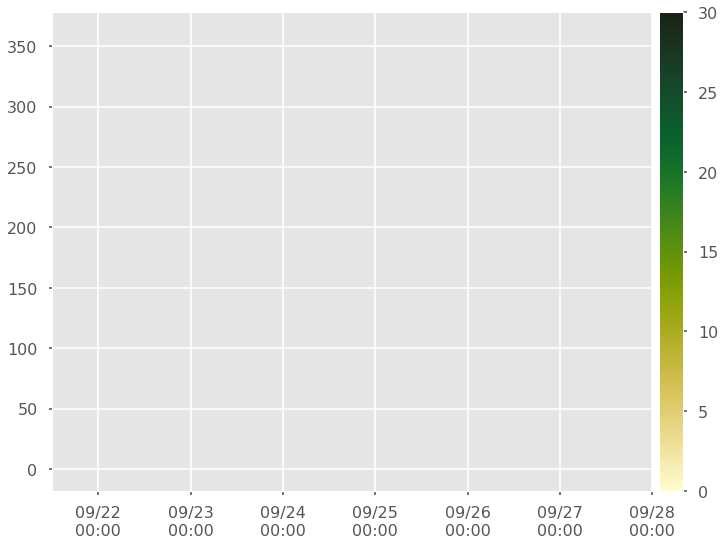

In [47]:
plt.scatter(ndb_datenum, winddir, c=windspeed, cmap=cmo.speed, s=70, vmin=0, vmax=30)
plt.colorbar(pad=0.01)
#plt.ylim([0, 25])
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)

In [48]:
plt.scatter(datenum[0,:,:], -df.depth[0,:,:], c=df.temperature[0,:,:], s=36, cmap=cmo.thermal)
plt.colorbar(pad=0.01, label="temperature [C]")
plt.plot(ndb_datenum, -1*(windspeed), c='w')
plt.xlim([mdates.date2num(datetime.datetime(2020,8,4,12)), mdates.date2num(datetime.datetime(2020,8,4,18))])
plt.ylim([-80,0])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
depthlines = np.arange(50)+5
casttimes = datenum[0,:,0]
np.shape(casttimes)

DLINES, CTIMES = np.meshgrid(depthlines, casttimes)

In [ ]:
np.shape(DLINES)

In [ ]:
TLINES = np.ones_like(DLINES) * np.nan

for i, tnum in enumerate(casttimes[:]):
    d = df.depth[0,i,:].values
    temps = df.temperature[0,i,:].values
    maxD = np.nanmax(d)
    tgood = temps[np.isfinite(temps)]
    dgood = d[np.isfinite(temps)]
    sortq = np.argsort(dgood)
    tgood = tgood[sortq]
    dgood = dgood[sortq]
    q = np.where(depthlines < maxD)
    xx = depthlines[q]
    TLINES[i,:len(xx)] = np.interp(xx,dgood,tgood)
    #plt.plot(xx, np.interp(xx,dgood,tgood))

In [ ]:
import scipy.interpolate as interp

def pycnocline_width(profile_tmp, d, low=10.5, high=11.5):
    finite = np.where(np.isfinite(profile_tmp))[0]
    maxdepth = d[np.min(finite)]
    mindepth = d[np.max(finite)]
    new_d = np.arange(mindepth,maxdepth,0.1)
    y = interp.interp1d(d[finite],profile_tmp[finite], kind='linear')
    new_tmp = y(new_d)
    tmp_low = np.abs(new_tmp - low)
    tmp_high = np.abs(new_tmp - high)
    q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
    q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
    #delta_d = new_d[q_high] - new_d[q_low]
    return new_d[q_high], new_d[q_low]

np.shape(TLINES)

In [ ]:
low_depth  = np.ones_like(casttimes)
high_depth = np.ones_like(casttimes)

for I in range(len(casttimes)):
    new_tmp = TLINES[I,:]
    if sum(np.isfinite(new_tmp)) > 3:
        tmp_low = np.abs(new_tmp - 14)
        tmp_high = np.abs(new_tmp - 20)
        q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
        q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
        a, b = depthlines[q_high], depthlines[q_low]
        if np.abs(a-b) < 0.25:
            low_depth[I], high_depth[I] = np.nan, np.nan
        else:
            low_depth[I], high_depth[I] = a, b
    else: low_depth[I], high_depth[I] = np.nan, np.nan

In [ ]:
plt.contourf(CTIMES, -DLINES, TLINES, cmap='cmo.thermal', levels=np.arange(25)+5)
plt.xlim([start, enddd])
plt.colorbar(pad=0.01, label="temperature [C]")
plt.contour(CTIMES, -DLINES, TLINES, levels=np.array([14,20]), colors='w', linewidths=2)
plt.plot(ndb_datenum, 1*(windspeed), c='r')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.savefig('Isaias_2020_wind.pdf', bbox_inches='tight')

In [ ]:
plt.plot(casttimes, high_depth - low_depth)
plt.plot(ndb_datenum, (windspeed))
plt.plot(ndb_datenum, (winddir)*np.pi/180)
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim([0,25])
plt.ylabel('pycnocline width [m]')